Mateusz Cygiel - 76570
Temat: Analiza danych na temat zachorowań na nowotwór złośliwy w Polsce i predykcja liczby zachorowań. Dane pochodzą z lat 2000 do 2023 https://dane.gov.pl/pl/dataset/18216,zachorowania-na-nowotwory-zlosliwe-w-polsce-w-lata. Celem projektu jest prognoza liczby przypadków na kolejne lata. Liczba zachorowań od początku zbierania danych wzrasta, natomiast w 2019 roku widzimy drastyczny spadek spowodowany pandemią. Poźniej liczba zachorowań wzrasta do poprzendich wartości i stale rośnie.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet
from statsmodels.tsa.stattools import adfuller

from google.colab import files
uploaded = files.upload()

sns.set_style("whitegrid")
%matplotlib inline

Saving Zachorowania2000-2023_Polska.csv to Zachorowania2000-2023_Polska (1).csv


In [7]:
df = pd.read_csv('Zachorowania2000-2023_Polska.csv', sep=';', encoding='latin1')

# Utworzenie tabeli z danymi surowymi
print("Surowe dane:")
display(df.head())

# Agregacja
df_yearly = df.groupby('Rok')['Liczba'].sum().reset_index()

# Ustawienie roku jako indeksu
df_yearly['Rok'] = pd.to_datetime(df_yearly['Rok'], format='%Y')
df_yearly = df_yearly.set_index('Rok')
df_yearly.index.freq = 'YS'

print("\nDane po agregacji:")
display(df_yearly.head())


Surowe dane:


,Rok,ICD10,Plec,Grupa_wieku,Liczba
0,2000,C00,Kobieta,15-19,1
1,2000,C00,Kobieta,35-39,1
2,2000,C00,Kobieta,40-44,1
3,2000,C00,Kobieta,45-49,5
4,2000,C00,Kobieta,50-54,6



Dane po agregacji:


,Liczba
Rok,
2000-01-01,118835
2001-01-01,121995
2002-01-01,125295
2003-01-01,127525
2004-01-01,129345


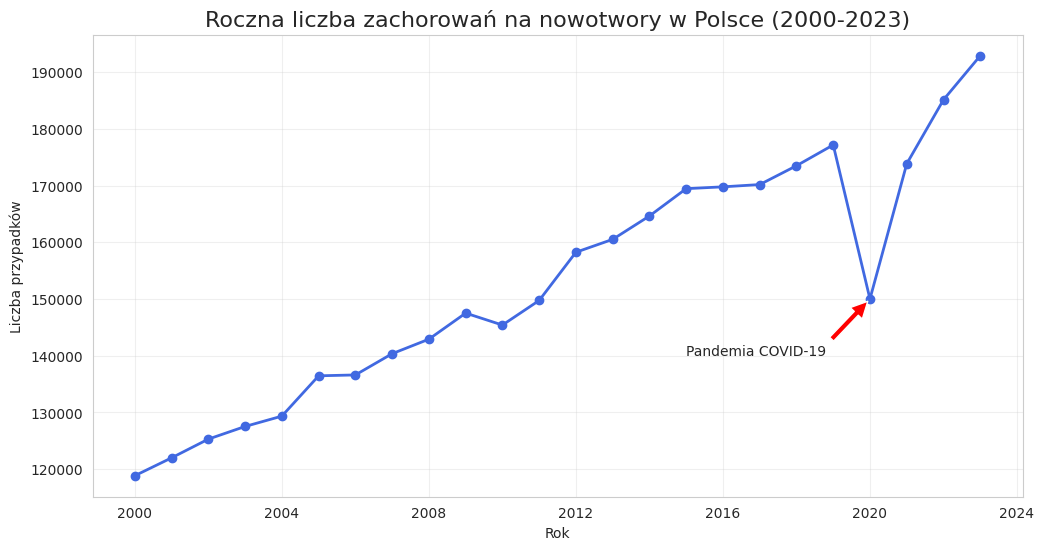

In [8]:
# Wizualizacja
plt.figure(figsize=(12, 6))
plt.plot(df_yearly.index, df_yearly['Liczba'], marker='o', linestyle='-', linewidth=2, color='royalblue')
plt.title('Roczna liczba zachorowań na nowotwory w Polsce (2000-2023)', fontsize=16)
plt.xlabel('Rok')
plt.ylabel('Liczba przypadków')
plt.grid(True, alpha=0.3)

# zaznaczenie COVID-19
plt.annotate('Pandemia COVID-19', xy=(pd.to_datetime('2020-01-01'), 150014),
             xytext=(pd.to_datetime('2015-01-01'), 140000),
             arrowprops=dict(facecolor='red', shrink=0.05))

plt.show()

Wyniki testu Dickeya-Fullera
Statystyka ADF: -0.308096016621728
p-value: 0.9243498414891057
Wniosek: Szereg jest NIESTACJONARNY (p-value > 0.05). Występuje wyraźny trend.


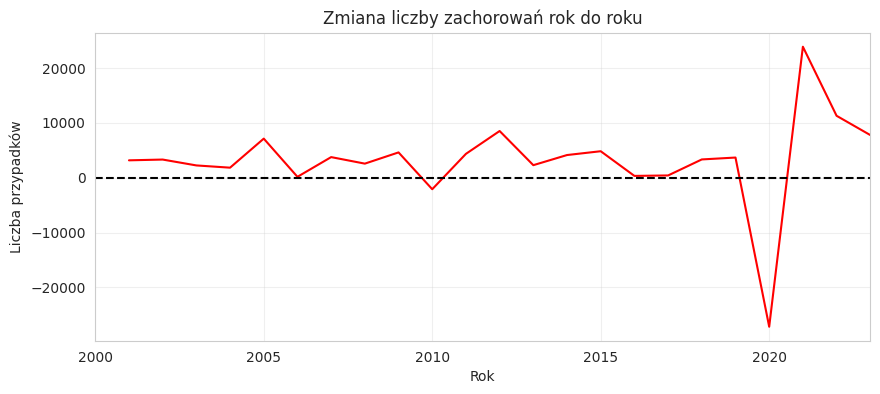

In [12]:
# Test Dickeya-Fullera
print("Wyniki testu Dickeya-Fullera")
result = adfuller(df_yearly['Liczba'])
print(f'Statystyka ADF: {result[0]}')
print(f'p-value: {result[1]}')

if result[1] > 0.05:
    print("Wniosek: Szereg jest NIESTACJONARNY (p-value > 0.05). Występuje wyraźny trend.")
else:
    print("Wniosek: Szereg jest STACJONARNY.")

# Wykres zmian rok do roku
plt.figure(figsize=(10, 4))
df_yearly['Liczba'].diff().plot(title='Zmiana liczby zachorowań rok do roku', color='red')
plt.axhline(0, color='black', linestyle='--')
plt.ylabel('Liczba przypadków')
plt.grid(True, alpha=0.3)
plt.show()

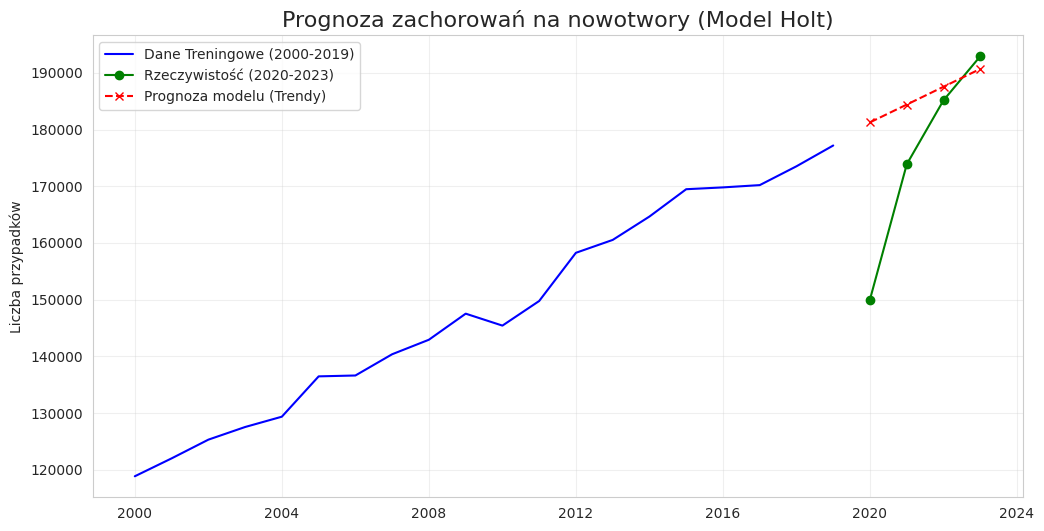

Średni błąd bezwzględny (MAE): 11600 przypadków

Różnice (Prognoza vs Rzeczywistość):
            Rzeczywiste       Prognoza       Różnica
2020-01-01       150014  181265.562988 -31251.562988
2021-01-01       173881  184406.890059 -10525.890059
2022-01-01       185159  187548.217130  -2389.217130
2023-01-01       192922  190689.544201   2232.455799
MAE (Średni Błąd): 11600
RMSE (Błąd Średniokwadratowy): 16569
MAPE (Błąd Procentowy): 7.33%


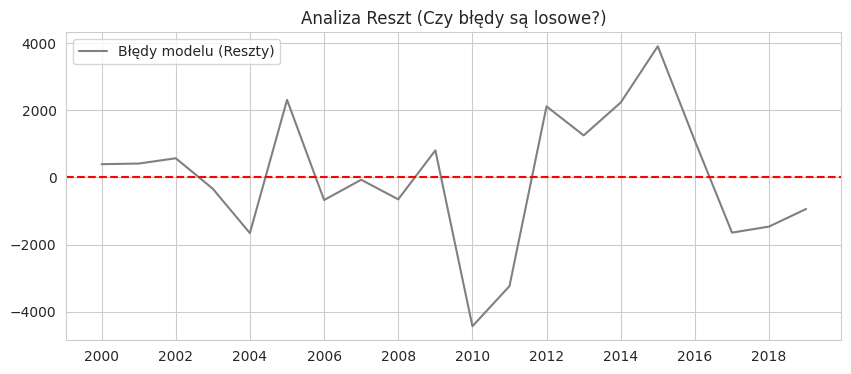

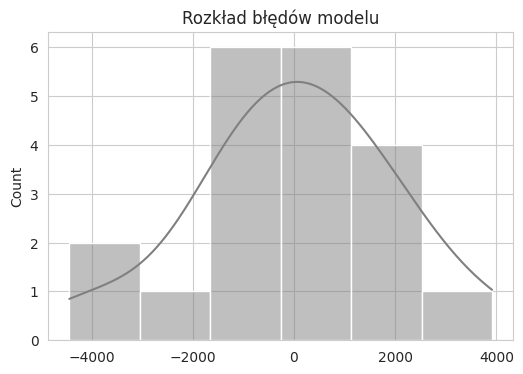

In [13]:
# podział na zbiór treningowy i testowy
train = df_yearly.iloc[:-4]
test = df_yearly.iloc[-4:]

# metoda Holta - dla danych z trendem
model = ExponentialSmoothing(train['Liczba'], trend='add', seasonal=None).fit()
forecast = model.forecast(steps=len(test))
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Liczba'], label='Dane Treningowe (2000-2019)', color='blue')
plt.plot(test.index, test['Liczba'], label='Rzeczywistość (2020-2023)', color='green', marker='o')
plt.plot(test.index, forecast, label='Prognoza modelu (Trendy)', color='red', linestyle='--', marker='x')

plt.title('Prognoza zachorowań na nowotwory (Model Holt)', fontsize=16)
plt.ylabel('Liczba przypadków')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Ocena modelu
mae = mean_absolute_error(test['Liczba'], forecast)
print(f"Średni błąd bezwzględny (MAE): {mae:.0f} przypadków")
print("\nRóżnice (Prognoza vs Rzeczywistość):")
results = pd.DataFrame({'Rzeczywiste': test['Liczba'], 'Prognoza': forecast})
results['Różnica'] = results['Rzeczywiste'] - results['Prognoza']
print(results)

mse = mean_squared_error(test['Liczba'], forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test['Liczba'] - forecast) / test['Liczba'])) * 100

print(f"MAE (Średni Błąd): {mae:.0f}")
print(f"RMSE (Błąd Średniokwadratowy): {rmse:.0f}")
print(f"MAPE (Błąd Procentowy): {mape:.2f}%")

# Analiza Reszt na zbiorze treningowym
residuals = model.resid
plt.figure(figsize=(10, 4))
plt.plot(residuals, label='Błędy modelu (Reszty)', color='gray')
plt.axhline(0, color='red', linestyle='--')
plt.title('Analiza Reszt (Czy błędy są losowe?)')
plt.legend()
plt.show()

# Histogram błędów
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True, color='gray')
plt.title('Rozkład błędów modelu')
plt.show()

Analiza wykazała silny trend wzrostowy. Dane są niestacjonarne. W latach 2000-2019 model precyzyjnie odwzorowywał dane, ale pandemia covid-19 to zaburzyła, nastąpiło załamanie trendu. W latach 2022-2023 liczba zachorowań wróciła do oczekiwanego poziomu, dzięki wzrostowi dostępu do diagnostyki.